##**Create Block and Nets**

In [1]:
!pip install wfdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 137 kB 15.5 MB/s 
     |████████████████████████████████| 11.2 MB 41.1 MB/s 
     |████████████████████████████████| 930 kB 49.2 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
# imports
import torch.nn as nn
import torch.nn.functional as F
import scipy
import pandas as pd
import numpy as np
import wfdb
import ast
import torch
import time
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim


In [3]:
# load drive 
from google.colab import drive 
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import os
os.chdir("drive/My Drive/")

In [5]:
!pip uninstall matplotlib
!pip install matplotlib==3.1.3
%matplotlib inline


Found existing installation: matplotlib 3.5.2
Uninstalling matplotlib-3.5.2:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.2.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 15.9 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [ ]:
# !wget -r -N -c -np https://physionet.org/files/challenge-2018/1.0.0/

In [ ]:
!ls

## Network blocks

In [6]:
class TemporalBlock(nn.Module):
    def __init__(self,input_dim,output_dim,kernel,max_pool):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size=(kernel))
        self.BN = nn.BatchNorm1d(output_dim)
        self.MP = nn.MaxPool1d(max_pool)
        

    def forward(self, x):
        x = self.conv1(x)
        # print('conv',x)
        x = F.relu(self.BN(x))
        # print('relu+BN',x)
        x = self.MP(x)
        # print('MP',x)

        return x

In [7]:
class SpatialBlock(nn.Module):
    def __init__(self,input_dim,output_dim,kernel,max_pool):
        super().__init__()
        self.conv1 = nn.Conv1d(input_dim, output_dim, kernel_size=(kernel))
        self.BN = nn.BatchNorm1d(output_dim)
        self.MP = nn.MaxPool1d(max_pool)
        

    def forward(self, x):
        x = self.conv1(x)
        
        x = F.relu(self.BN(x))
        
        x = self.MP(x)
        

        return x

In [8]:
class FCBlock(nn.Module):
    def __init__(self,input_dim,output_dim):
        super().__init__()
        self.FC = nn.Linear(input_dim, output_dim)
        self.BN = nn.BatchNorm1d(output_dim)
        

    def forward(self, x):
        x = self.FC(x)
        x = F.relu(self.BN(x))
        x = F.dropout(x)

        return x

In [9]:
class SexNet(nn.Module):
  
    def __init__(self):
        super().__init__()
        self.Temp1 = TemporalBlock(12,16,7,2)
        self.Temp2 = TemporalBlock(16,16,5,4)
        self.Temp3 = TemporalBlock(16,32,4,2)
        self.Temp4 = TemporalBlock(32,32,5,4)
        self.Temp5 = TemporalBlock(32,64,5,2)
        self.Temp6 = TemporalBlock(64,64,3,2)
        self.Temp7 = TemporalBlock(64,64,3,2)
        self.Temp8 = TemporalBlock(64,64,3,1)
        self.Spat = SpatialBlock(5,128,12,2)
        self.FC1 =  FCBlock(128*26,128)
        self.FC2 =  FCBlock(128,64)
        self.out = nn.Linear(64,2)

    def forward(self, x):
        x = self.Temp1(x)
        x = self.Temp2(x)
        x = self.Temp3(x)
        x = self.Temp4(x)
        x = self.Temp5(x)
        x = self.Temp6(x)
        x = self.Temp7(x)
        x = self.Temp8(x)

        x = torch.swapaxes(x, 1,2)
        x = self.Spat(x)
        x = x.view(x.shape[0],-1)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.out(x)

        return x

In [10]:
class AgeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.Temp1 = TemporalBlock(12,16,7,2)
        self.Temp2 = TemporalBlock(16,16,5,4)
        self.Temp3 = TemporalBlock(16,32,4,2)
        self.Temp4 = TemporalBlock(32,32,5,4)
        self.Temp5 = TemporalBlock(32,64,5,2)
        self.Temp6 = TemporalBlock(64,64,3,2)
        self.Temp7 = TemporalBlock(64,64,3,2)
        self.Temp8 = TemporalBlock(64,64,3,1)
        self.Spat = SpatialBlock(5,128,12,2)

        self.FC1 =  FCBlock(128*26,128)
        self.FC2 =  FCBlock(128,64)
        self.out = nn.Linear(64,1)

    def forward(self, x):
        x = self.Temp1(x)
        x = self.Temp2(x)
        x = self.Temp3(x)
        x = self.Temp4(x)
        x = self.Temp5(x)
        x = self.Temp6(x)
        x = self.Temp7(x)
        x = self.Temp8(x)
        x = torch.swapaxes(x, 1,2)
        x = self.Spat(x)
        x = x.view(x.shape[0],-1)
        x = self.FC1(x)
        x = self.FC2(x)
        x = self.out(x)

        return x

In [11]:
def writeCSVLoggerFile(csvLoggerFile_path,log):
    df = pd.DataFrame([log])
    with open(csvLoggerFile_path, 'a') as f:
        df.to_csv(f, mode='a', header=f.tell() == 0, index=False)

### Load Data


In [12]:
def load_raw_data(df, sampling_rate):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

sampling_rate=500

## According to the data ducomentation it's suggested to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

# Split data into train, validation and test
test_fold = 10
val_fold = 9 

# load and convert annotation data
Y = pd.read_csv('ptbxl_database.csv', index_col='ecg_id')[:20]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate)
X_pad = np.zeros((X.shape[0],X.shape[1]+120,X.shape[2]))
X_pad[:,60:-60,:] = X


# Train
X_train = torch.Tensor(X_pad[np.where(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)))])
y_train_sex = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)))].sex.values)
y_train_age = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)))].age.values)

# Validation 
X_val =torch.Tensor(X_pad[np.where(Y.strat_fold == val_fold)])
y_val_sex = torch.Tensor(Y[Y.strat_fold == val_fold].sex.values)
y_val_age = torch.Tensor(Y[Y.strat_fold == val_fold].age.values)

# Test
X_test =torch.Tensor( X_pad[np.where(Y.strat_fold == test_fold)])
y_test_sex = torch.Tensor(Y[Y.strat_fold == test_fold].sex.values)
y_test_age = torch.Tensor(Y[Y.strat_fold == test_fold].age.values)

# Create dataloader
age_dataset_train = TensorDataset(X_train,y_train_age) 
sex_dataset_train = TensorDataset(X_train,y_train_sex) 

age_dataset_val = TensorDataset(X_val,y_val_age) 
sex_dataset_val = TensorDataset(X_val,y_val_sex) 

age_dataset_test = TensorDataset(X_test,y_test_age) 
sex_dataset_test = TensorDataset(X_test,y_test_sex) 

train_dataloader_sex = DataLoader(sex_dataset_train , batch_size=16, shuffle=True)
train_dataloader_age = DataLoader(age_dataset_train, batch_size=64, shuffle=True)

val_dataloader_sex = DataLoader(sex_dataset_val , batch_size=16, shuffle=False)
val_dataloader_age = DataLoader(age_dataset_val, batch_size=64, shuffle=False)

test_dataloader_sex = DataLoader(sex_dataset_test , batch_size=16, shuffle=False)
test_dataloader_age = DataLoader(age_dataset_test, batch_size=64, shuffle=False)
training_log_age = {}
validaiting_log_age = {}
training_log_sex = {}
validaiting_log_sex = {}

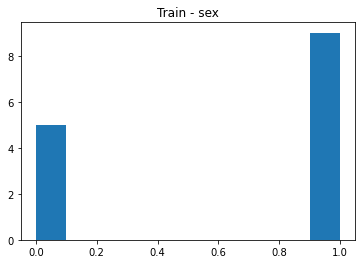

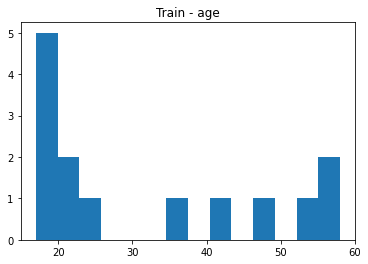

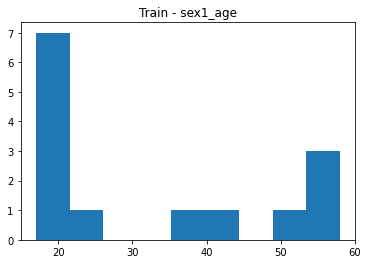

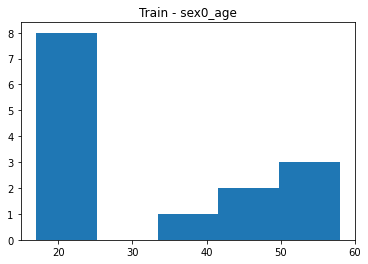

In [25]:
# data analysis
import matplotlib.pyplot as plt

plt.hist(y_train_sex)
plt.title('Train - sex')
plt.show()

plt.hist(y_train_age, bins=len(y_train_age) )
plt.title('Train - age')
plt.show()


# sex=1, age distrebution
y_sex1_age = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold) & (Y.sex == 1)))].age.values)
plt.hist(y_train_age, bins=len(y_sex1_age) )
plt.title('Train - sex1_age')
plt.show()

# sex=0, age distrebution
y_sex0_age = torch.Tensor(Y[(((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold) & (Y.sex == 0)))].age.values)
plt.hist(y_train_age, bins=len(y_sex0_age) )
plt.title('Train - sex0_age')
plt.show()

In [ ]:
start_time = time.strftime("_%d_%m_%Y_%H_%M")
result_dir = '/content/drive/MyDrive/results_2' +'/' + start_time 
os.makedirs(result_dir, exist_ok=True)
writer = SummaryWriter(result_dir + '/' + 'tensor_logs')
save_each = 5


if not os.path.isdir(result_dir +'/Saved'+ '/Periodic_save'):
  os.makedirs(result_dir +'/Saved' +'/Periodic_save', exist_ok=True)

if not os.path.isdir(result_dir +'/Saved'+ '/Best_model_save'):
  os.makedirs(result_dir +'/Saved' +'/Best_model_save', exist_ok=True)
csvLoggerFile_path_train_age = os.path.join(result_dir, "history_train_age.csv")
csvLoggerFile_path_val_age = os.path.join(result_dir, "history_val_age.csv")
csvLoggerFile_path_train_sex = os.path.join(result_dir, "history_train_sex.csv")
csvLoggerFile_path_val_sex = os.path.join(result_dir, "history_val_sex.csv")


In [ ]:
age_net = AgeNet()
print(age_net)
sex_net = SexNet()
print(sex_net)
criterion_age = nn.MSELoss()
optimizer_age = optim.Adam(age_net.parameters(), lr=0.0001)

criterion_sex = nn.BCEWithLogitsLoss()
optimizer_sex = optim.Adam(sex_net.parameters(), lr=0.0001)


In [ ]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
validation_losses = []
age_net = age_net.to(device, non_blocking=True)


for epoch in range(20):  # loop over the dataset multiple times
    print (epoch)
    running_loss = 0.0
    for i, data in enumerate(train_dataloader_age, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # print('Before-',inputs)
        inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
        labels = labels.to(device, non_blocking=True, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
        # print('Aftre-',inputs)

        # zero the parameter gradients
        optimizer_age.zero_grad()

        # forward + backward + optimize
        outputs = age_net(inputs)
        outputs[labels.isnan()]=0
        labels[labels.isnan()]=0
        loss = criterion_age(outputs, labels)
        print(loss.item())
        loss.backward()
        optimizer_age.step()

        # print statistics
        running_loss += loss.item()


    print(running_loss,i)
    print(f'epoch [{epoch + 1}] - train_avg_loss: {running_loss / i}')
    writer.add_scalar("Train/Age_Loss", running_loss / i, epoch)   
    training_log_age["epoch"] = epoch
    training_log_age["ave_loss"] = running_loss / i
    writeCSVLoggerFile(csvLoggerFile_path_train_age,training_log_age)
    with torch.no_grad():
            
        age_net.eval()
        val_loss = 0.0

        for i, val_data in enumerate(val_dataloader_age,0):

            inputs, labels = val_data
            inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
            labels = labels.to(device, non_blocking=True, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = age_net(inputs)
            #print(labels, outputs)
            outputs[labels.isnan()]=0
            labels[labels.isnan()]=0
            loss = criterion_age(outputs, labels)
            
            #print(loss.item())
            val_loss += loss.item()

        validation_losses.append(val_loss)  

    print(f'epoch [{epoch + 1}] - val_avg_loss: {val_loss}')
    writer.add_scalar("Validation/Age_Loss", val_loss, epoch)
    validaiting_log_age["epoch"] = epoch
    validaiting_log_age["ave_loss"] = val_loss / i
    writeCSVLoggerFile(csvLoggerFile_path_val_age,validaiting_log_age)
    
    if epoch == 0:
        best_loss = val_loss
    
    # save best model
    if epoch > 0  and validation_losses[-1] < best_loss:
        best_loss = validation_losses[-1]    
        print('save best')
        torch.save({
            'age_net': age_net.state_dict(),
            'optimizer_age': optimizer_age.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved','Best_model_save', f"AgeNet.pth"))              

    # save each % epoch 
    if epoch > 0  and epoch % save_each == 0:
        print('save epoch')
        torch.save({
            'age_net': age_net.state_dict(),
            'optimizer_age': optimizer_age.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved','Periodic_save', f"AgeNet.pth"))
        
torch.cuda.empty_cache()   
print('Finished Training')


In [ ]:
# start_time = time.strftime("_%d_%m_%Y_%H_%M")
# result_dir = '/content/drive/MyDrive/results_2' +'/' + start_time 
# os.makedirs(result_dir, exist_ok=True)
# writer = SummaryWriter(result_dir + '/' + 'tensor_logs')
# save_each = 5


if not os.path.isdir(result_dir +'/Saved_sex'+ '/Periodic_save'):
  os.makedirs(result_dir +'/Saved_sex' +'/Periodic_save', exist_ok=True)

if not os.path.isdir(result_dir +'/Saved_sex'+ '/Best_model_save'):
  os.makedirs(result_dir +'/Saved_sex' +'/Best_model_save', exist_ok=True)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
validation_losses = []
sex_net = sex_net.to(device, non_blocking=True)


for epoch in range(12):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_dataloader_sex, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
        labels = labels.to(device, non_blocking=True, dtype=torch.float)
        inputs = inputs.permute(0,2,1)
       
        # zero the parameter gradients
        optimizer_sex.zero_grad()

        # forward + backward + optimize
        outputs = sex_net(inputs)
        loss = criterion_sex(outputs, F.one_hot(labels.to(torch.int64),2).float())
        loss.backward()
        optimizer_sex.step()

        # print statistics
        running_loss += loss.item()
    print(running_loss,i)
    print(f'epoch [{epoch + 1}] - train_avg_loss: {running_loss / i}')
    writer.add_scalar("Train/sex_Loss", running_loss / i, epoch)   
    training_log_sex["epoch"] = epoch
    training_log_sex["ave_loss"] = running_loss / i
    writeCSVLoggerFile(csvLoggerFile_path_train_sex,training_log_sex)
    with torch.no_grad():
            
        sex_net.eval()
        val_loss = 0.0

        for i, val_data in enumerate(val_dataloader_sex,0):

            inputs, labels = val_data
            inputs = inputs.to(device, non_blocking=True, dtype=torch.float)
            labels = labels.to(device, non_blocking=True, dtype=torch.float)
            inputs = inputs.permute(0,2,1)
            outputs = sex_net(inputs)

            loss = criterion_sex(outputs, F.one_hot(labels.to(torch.int64),2).float())
            print(loss.item())
            val_loss += loss.item()

        validation_losses.append(val_loss)  

    print(f'epoch [{epoch + 1}] - val_avg_loss: {val_loss}')
    writer.add_scalar("Validation/sex_Loss", val_loss, epoch)
    validaiting_log_sex["epoch"] = epoch
    validaiting_log_sex["ave_loss"] = val_loss / i
    writeCSVLoggerFile(csvLoggerFile_path_val_sex,validaiting_log_sex)
    
    if epoch == 0:
        best_loss = val_loss
    
    # save best model
    if epoch > 0  and validation_losses[-1] < best_loss:
        best_loss = validation_losses[-1]    
        print('save best')
        torch.save({
            'sex_net': sex_net.state_dict(),
            'optimizer_sex': optimizer_sex.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_sex','Best_model_save', f"SexNet.pth"))              

    # save each % epoch 
    if epoch > 0  and epoch % save_each == 0:
        print('save epoch')
        torch.save({
            'sex_net': sex_net.state_dict(),
            'optimizer_sex': optimizer_sex.state_dict(),
            'epoch': epoch+1},
            os.path.join(result_dir,'Saved_sex','Periodic_save', f"SexNet.pth"))
        
print('Finished Training')

## Evaluate model

In [ ]:

from sklearn.metrics import roc_auc_score
from sklearn import metrics
# import scikitplot as skplt
import matplotlib.pyplot as plt

sex_net = sex_net.to(device, non_blocking=True)
sex_net.eval()
outputs_test_all = []
label_test_all = []
outputs_val_all = []
label_val_all = []
for i, test_data in enumerate(test_dataloader_sex,0):

            inputs_test, labels_test = test_data
            inputs_test = inputs_test.to(device, non_blocking=True, dtype=torch.float)
            labels_test = labels_test.to(device, non_blocking=True, dtype=torch.float)
            inputs_test = inputs_test.permute(0,2,1)
            outputs_test = sex_net(inputs_test)
            outputs_test_all.append(outputs_test)
            label_test_all.append(labels_test)

outputs_test_all = torch.cat(outputs_test_all,dim = 0)
label_test_all = torch.cat(label_test_all,dim = 0)

# pred_test_sex = outputs_test.detach().cpu().numpy()
# y_test_sex_new = F.one_hot(y_test_sex.to(torch.int64),2).float()
# auc_test = roc_auc_score(y_test_sex_new, pred_test_sex)
pred_test_sex = outputs_test_all.detach().cpu().numpy()
# label_test_all = label_test_all.detach().cpu().numpy()
y_test_sex_new = F.one_hot(label_test_all.to(torch.int64),2).float().detach().cpu().numpy()
auc_test = roc_auc_score(y_test_sex_new, pred_test_sex)



for i, val_data in enumerate(val_dataloader_sex,0):

            inputs_val, labels_val = val_data
            inputs_val = inputs_val.to(device, non_blocking=True, dtype=torch.float)
            labels_val = labels_val.to(device, non_blocking=True, dtype=torch.float)
            inputs_val = inputs_val.permute(0,2,1)
            outputs_val = sex_net(inputs_val)
            outputs_val_all.append(outputs_val)
            label_val_all.append(labels_val)

outputs_val_all = torch.cat(outputs_val_all,dim = 0)
label_val_all = torch.cat(label_val_all,dim = 0)

pred_val_sex = outputs_val_all.detach().cpu().numpy()
y_val_sex_new = F.one_hot(label_val_all.to(torch.int64),2).float().detach().cpu().numpy()
auc_val = roc_auc_score(y_val_sex_new, pred_val_sex)

# metrics.plot_roc_curve(sex_net, X_test, label_test_all) 
# plt.show()
# skplt.metrics.plot_roc_curve(y_test_sex_new, pred_test_sex)
# plt.show()


print(f'AUC test:{auc_test}')
print(f'AUC val:{auc_val}')

In [ ]:




# take the second column because the classifier outputs scores for
# the 0 class as well


# fpr means false-positive-rate
# tpr means true-positive-rate
fpr, tpr, _ = metrics.roc_curve(label_test_all.detach().cpu().numpy(), outputs_test_all[:,1].detach().cpu().numpy())

auc_score = metrics.auc(fpr, tpr)

# clear current figure


plt.title('ROC Curve')
plt.plot(fpr, tpr, label='AUC = {:.2f}'.format(auc_score))

# it's helpful to add a diagonal to indicate where chance 
# scores lie (i.e. just flipping a coin)
plt.plot([0,1],[0,1],'r--')

plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.legend(loc='lower right')
plt.show()

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt


age_net = age_net.to(device, non_blocking=True)
age_net.eval()

outputs_test_all = []
label_test_all = []
outputs_val_all = []
label_val_all = []


for i, test_data in enumerate(test_dataloader_age,0):

            inputs_test, labels_test = test_data
            inputs_test = inputs_test.to(device, non_blocking=True, dtype=torch.float)
            labels_test = labels_test.to(device, non_blocking=True, dtype=torch.float)
            inputs_test = inputs_test.permute(0,2,1)
            outputs_test = age_net(inputs_test)
            outputs_test_all.append(outputs_test)
            label_test_all.append(labels_test)

outputs_test_all = torch.cat(outputs_test_all,dim = 0)
label_test_all = torch.cat(label_test_all,dim = 0).detach().cpu().numpy()

pred_test_age = outputs_test_all.detach().cpu().numpy()
pred_test_age[np.isnan(label_test_all)]=np.nan
#label_test_all[np.isnan(label_test_all)]=0
plt.figure()
plt.scatter(label_test_all, pred_test_age.squeeze())
plt.title('Test set')
plt.xlabel('real age')
plt.ylabel('cnn prediction')
plt.show()

for i, val_data in enumerate(val_dataloader_age,0):

            inputs_val, labels_val = val_data
            inputs_val = inputs_val.to(device, non_blocking=True, dtype=torch.float)
            labels_val = labels_val.to(device, non_blocking=True, dtype=torch.float)
            inputs_val = inputs_val.permute(0,2,1)
            outputs_val = age_net(inputs_val)
            outputs_val_all.append(outputs_val)
            label_val_all.append(labels_val)

outputs_val_all = torch.cat(outputs_val_all,dim = 0)


label_val_all = torch.cat(label_val_all,dim = 0).detach().cpu().numpy()
pred_val_age = outputs_val_all.detach().cpu().numpy()
pred_val_age[np.isnan(label_val_all)]=np.nan
# label_val_all[np.isnan(label_val_all)]=0
plt.figure()
plt.scatter(label_val_all, pred_val_age)
plt.title('Validation set')
plt.xlabel('real age')
plt.ylabel('cnn prediction')
plt.show()


# data = {'A': [45,37,42,35,39],
#         'B': [38,31,26,28,33],
#         'C': [10,15,17,21,12]
#         }

# df = pd.DataFrame(data,columns=['A','B','C'])

# corrMatrix = df.corr()
# sn.heatmap(corrMatrix, annot=True)
# plt.show()

In [ ]:
# torch.cuda.empty_cache()   
